# `dIdV.ipynb`

Notebook for dIdV study fits

- didv notes:
- square wave
- 100 Hz
- 20 mV
- gain 50
- offx - QET bias in V

In [5]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [7]:
# base location of "B13_Runs" folder
folder_base_candidates = [
    'D:', # on the cryolab2 computer
    '/Volumes/B13Cryolab_Share' # connecting to shared drives from Mac
]

folder_base = find_folder('B13_Runs', *folder_base_candidates)
print(folder_base)

/Volumes/B13Cryolab_Share


In [8]:
# read in results from IbIs analysis
with open('./ibis_data/local/20241108-0001_results.dat', 'rb') as f:
    ibis, ivfits, tr_fits = pickle.load(f)

In [9]:
# config dict
drive_path = folder_base + '/B13_Runs/Run96/didv_data/20241108-0002'
runnum = '20241108-0002'
channels = 'ABCDE'

didv = PicoscopeData(runnum, drive_path, idx = range(1,335), vertical_stack = True)

Created new PicoscopeData object with 100004 data points
Channels: ['A', 'B', 'C', 'D', 'E', 'H']


In [10]:
R_ops = tr_fits.loc['R_op'].values
R_ops*1e3 # milliohms

array([ 45.07022784, 395.98952668,  42.9394233 ,  45.10590655,
        44.50739942])

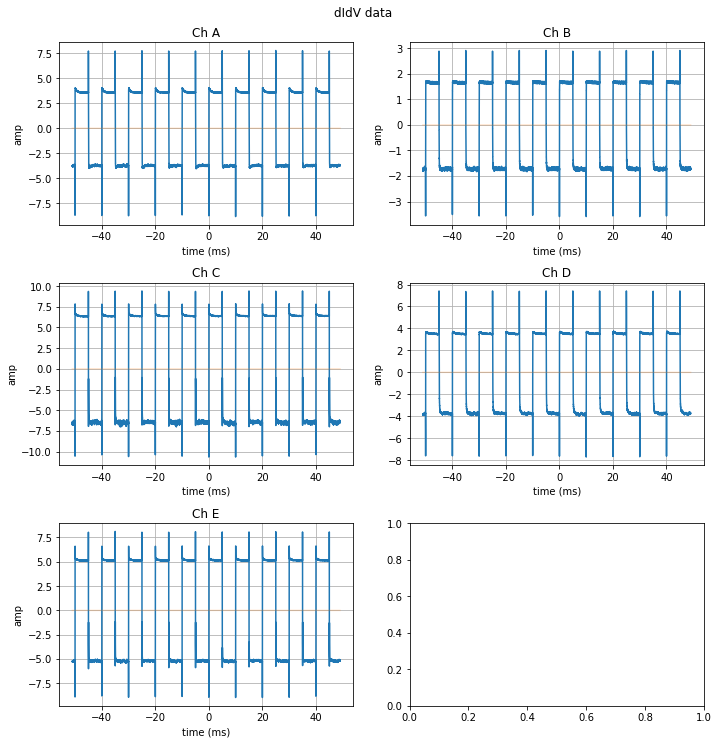

In [11]:
# plot DIDV data
numrows = 1 + int(len(channels)//2)

didv_waveform = didv('H')[0]

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('dIdV data')


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    ax.plot(didv.ts*1e3, didv(c)[0])
    ax.plot(didv.ts*1e3, didv('H')[0]/10, alpha = 0.2)
    #ax.plot(didv1.ts*1e3, didv1(c))

fig.tight_layout()


In [12]:
ff = np.round(1/((np.diff(didv.ts)).mean()))
freq = 100

ff, freq, ff/freq, didv.ts.size/10

(1000000.0, 100, 10000.0, 10000.4)

In [13]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'offA': 80.1,
 'offB': 59.1,
 'offC': 89.4,
 'offD': 82.5,
 'offE': 93.3,
 'gain': 50.0}

In [29]:
didvfit = {}

for i, c in enumerate(channels):
    didvfit[c] = qp.DIDV(
        rawtraces = to_ADC(didv(c), didv.config),
        fs = np.round(1/((np.diff(didv.ts)).mean())),
        sgfreq = didv.config['freq'],
        sgamp = to_ibias(didv.config['amp']),
        rsh = didv.config['rsh'],
        rp = ivfits.rp[0,i],
        dutycycle = 0.5,
        add180phase = False,
        #autoresample = True,
        r0 = R_ops[i], # estimated TES resistance (Ohms)
        tracegain = 1,#(didv.config['gain'])*(10)*(1.2e3), # what to divide by to convert rawtraces to Amps (from convert_ADC)
        dt0 = 1.e-3 # guess
        )

    didvfit[c].processtraces()

In [31]:
# fit 
for c in channels:
    #didvfit[c].dofit(2) # Two poles fit
    didvfit[c].dofit(3) # Tree poles fit


In [32]:
for c in channels:
    for p in (2,3):
        print(c, ',', p, 'pole:', didvfit[c].fitresult()[p]['params']['dt'])

A , 2 pole: 0.0010051167068117666
A , 3 pole: 0.0010100368669967812
B , 2 pole: 0.0010013110531015515
B , 3 pole: 0.0010059564628428243
C , 2 pole: 0.0009666260489971208
C , 3 pole: 0.0009894190769319838
D , 2 pole: 0.0010033778010439531
D , 3 pole: 0.0010088532078649478
E , 2 pole: 0.0010049850850380653
E , 3 pole: 0.0010034443619557959


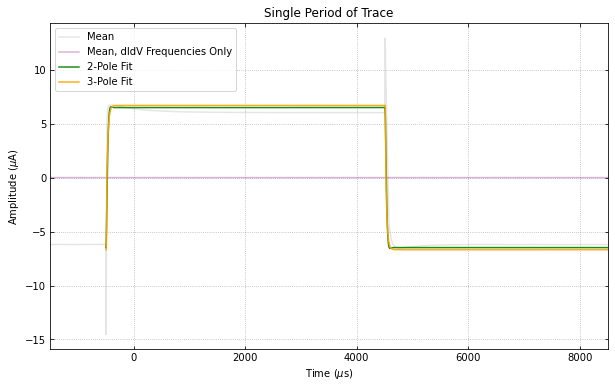

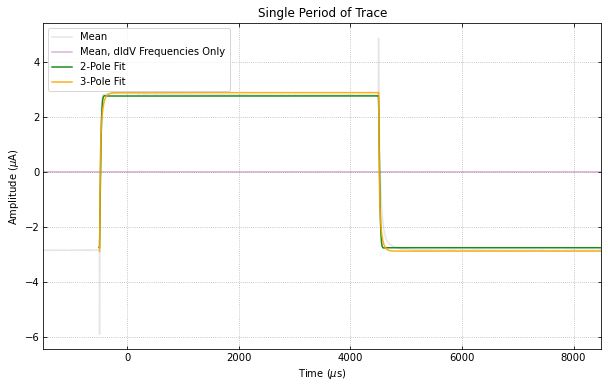

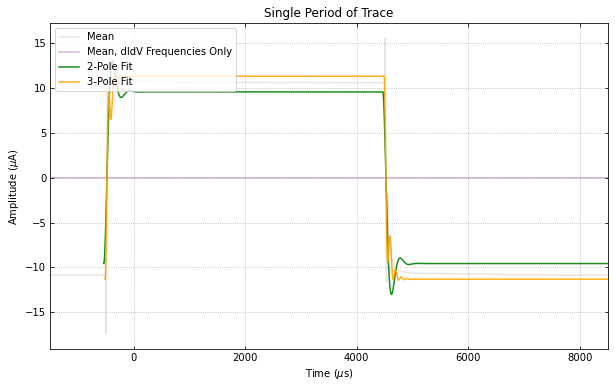

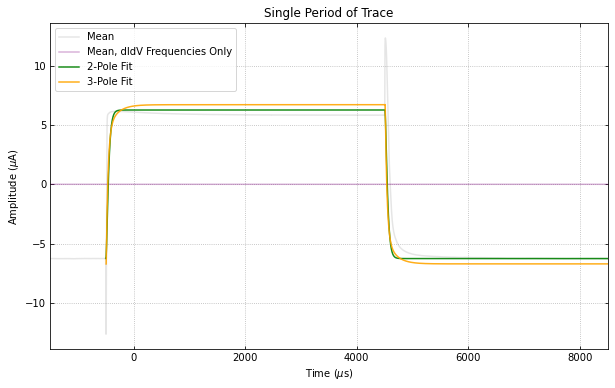

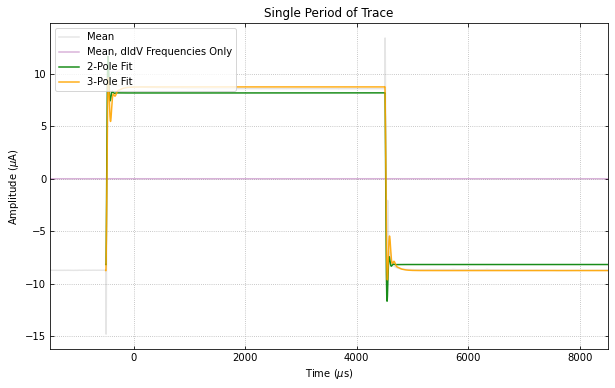

In [33]:
# display
for c in channels:
    didvfit[c].plot_single_period_of_trace(didv_freq_filt=True)
    #didvfit[c].plot_re_im_didv()

In [34]:
# "required params" ['rp', 'i0', 'i0_err','r0', 'r0_err']

In [35]:
ivfits.rp[0]
#didv.config['offA']

array([0.00985337, 0.02019479, 0.020179  , 0.01975472, 0.01522721])

In [36]:
# dict used to calculate small signal params
for i, c in enumerate(channels):
    """
    ivsweep_results_fromdemo = {
        'close_loop_norm': 10*1.2e3*2, # idk (see above)
        'group_name_sweep': 'iv_didv_I2_D20230923_T131239',
        'i0': didv.config['off'+c]/1e6, # ?? from Irwin chapter the "steady state" current given as I0 (A) (maybe ites?)
        # maybe baseline current outside of square wave amplitude?
        'i0_err': 0.,#8.342312444985714e-12,
        'i0_off': 0.,#3.89669341000469e-09, # ioff from DIDV? - the current offset (A)
        'i0_off_err': 0.,#5.507092047349402e-12,
        'i0_variable_offset': 0., #-9.865689873695374e-06, # ??
        'ibias': didv.config['off'+c]/1e6, # applied QET bias current (A) (ibias)
        'ibias_off': 0.,#-3.381406772500224e-08, # current offset of the QET bias (A)
        'ibias_off_err': 0.,#1.0347074588426951e-11,
        'lgc_invert_offset': True, 
        'output_variable_gain': 50.0, # see above
        'output_variable_offset': 0,#-0.12332112342119217, # see above
        'p0': 3.2911e-15, # power of TES (W)? (from bulk_tes_noise.ipynb)
        'p0_err': 5e-17,
        'r0': R_ops[i], # TES resistance (Ohms)?
        'r0_err': ivfits.rnorm_err[0,i], #0.003534606260879604,
        'rn': ivfits.rnorm[0,i], # normal-state resistance (Ohms) ?
        'rn_err': ivfits.rnorm_err[0,i], 
        'rp': ivfits.rp[0,i], # parasitic resistance in non-shunt side of TES circuit (see above) (Ohms)
        'rp_err': ivfits.rp_err[0,i],
        'rshunt': ibis.config['rsh'], # shunt resistance (Ohms)
        'rshunt_err': ibis.config['rsh']/100
        }"""

    ivsweep_results = {
        'rp': didvfit[c]._rp, #max((ivfits.rp[0,i], 0)), 
        'i0': didv.config['off'+c]/1e6, 
        'i0_err': didv.config['off'+c]/1e8,
        'r0': R_ops[i], 
        'r0_err': R_ops[i]/100
    }


    didvfit[c].calc_smallsignal_params(ivsweep_results)

INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 


In [37]:
didvfit['A'].fitresult(3).keys()

dict_keys(['lgcfix', 'params_array', 'params', 'cov', 'errors', 'falltimes', 'cost', 'offset', 'offset_err', 'biasparams', 'smallsignalparams', 'ssp_light', 'didv0', 'dpdi0', 'dpdi0_err'])

In [38]:
for c in channels:
        # printing out results
        results = didvfit[c].fitresult()
        data = {'Model':['2-pole', '3-pole'],
                'Tau1 [usec]': ['{:.3g}'.format(1e6*np.abs(results[2]['params']['tau1'])),
                                '{:.3g}'.format(1e6*np.abs(results[3]['params']['tau1']))],
                'Tau2 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau2']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau2'])],
                'Tau3 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau3']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau3'])]}
                
                
        
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('Fit time constants, NOT dIdV Poles: ')
        print(df.to_string(index = False))
                
        data = {'Model':['2-pole', '3-pole'],
                'Tau+[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][0]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][0])],
                'Tau-[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][1]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][1])],
                'Tau3[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][2]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][2])]}
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('\nTrue dIdV Poles: ')
        print(df.to_string(index = False))

        print('\n============\n')

Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole       0.838       0.766           0
3-pole       0.448       0.409        6.52

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       13.1       13.1          0
3-pole       2.57       2.57       23.1


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole       0.964       0.852           0
3-pole       0.451       0.362        27.1

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       11.9       11.9          0
3-pole       2.31        7.9       40.4


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole        1.26        1.22           0
3-pole        1.32        1.35        17.6

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       20.7       20.7          0
3-pole       5.14       5.44       54.5


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]

In [39]:
didvfit['C'].fitresult(3)['smallsignalparams']

{'rsh': 0.02,
 'rp': 0.020179000469826732,
 'r0': 0.042939423295829074,
 'beta': 314.67691227690784,
 'l': 101.60975223969295,
 'L': 1.8287618569765223e-05,
 'tau0': 0.00013273479336096684,
 'gratio': 0.8010590220783699,
 'tau3': 1.7603400789168774e-05,
 'dt': 0.0009894190769319838}

In [40]:
signalparams = pd.DataFrame.from_dict({param: [didvfit[c].fitresult(3)['smallsignalparams'][param] for c in channels] for param in ['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt']})
signalparams.index = list(channels)
signalparams.T

,A,B,C,D,E
rsh,0.020000,0.020000,0.020000,0.020000,0.020000
rp,0.009853,0.020195,0.020179,0.019755,0.015227
r0,0.045070,0.395990,0.042939,0.045106,0.044507
beta,336.941810,47.738818,314.676912,591.816209,433.834776
l,131.224799,-96.462530,101.609752,527.952389,456.891616
L,0.000006,0.000007,0.000018,0.000008,0.000013
tau0,0.000058,-0.000044,0.000133,0.000205,0.000310
gratio,0.702949,-0.189077,0.801059,0.128737,0.320971
tau3,0.000007,0.000027,0.000018,0.000135,0.000060
dt,0.001010,0.001006,0.000989,0.001009,0.001003


In [42]:
# calculate and plot dPdIs
if 0:
    for chan in channels:
        qp.get_dPdI_with_uncertainties(len(didv.ts)*didv.ts/4/(didv.ts[-1]-didv.ts[0])**2, didvfit[chan].fitresult()[3], lgcplot=True)

In [43]:
# save results
if 0:
    savefile = f'./didv_data/local/{runnum}_results.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = {c: didvfit[c].fitresult() for c in channels})
    print('saved data to', savefile)

saved data to ./didv_data/local/20241108-0002_results.dat
